In [4]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit

BASE = Path(".")
META = BASE / "HAM10000_metadata.csv"
IMG_DIR = BASE / "image"

df = pd.read_csv(META)

# 1) 이진 라벨 (악성=1)
malignant = ["mel", "bcc", "akiec"]
df["target"] = df["dx"].isin(malignant).astype(int)

# 2) 이미지 경로 생성 + 파일 존재 확인
df["image_path"] = df["image_id"].apply(lambda x: str(IMG_DIR / f"{x}.jpg"))
df = df[df["image_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)

# 3) lesion_id 기준 그룹 split (누수 방지)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, df["target"], groups=df["lesion_id"]))
train_df, test_df = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # train에서 val 분리
tr_idx, val_idx = next(gss2.split(train_df, train_df["target"], groups=train_df["lesion_id"]))
tr_df, val_df = train_df.iloc[tr_idx].copy(), train_df.iloc[val_idx].copy()

print(len(tr_df), len(val_df), len(test_df))
print("train malignant ratio:", tr_df["target"].mean())


6412 1579 2024
train malignant ratio: 0.19915782907049281


메타데이터에서 라벨 만들기

6412 : train set(학습용 이미지 수)
1579 : validation set(검증용 이미지 수)
2024 : test set(최종 평가용 이미지 수)
악성비율 : 19%

- 비어있는 데이터 없음

Lesion-level 기준으로 데이터를 분할한 결과,
학습·검증·테스트 세트가 안정적으로 구성되었으며,
학습 세트 내 악성 비율은 약 20%로
실제 임상 데이터의 불균형 특성을 유지하였다

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
import tensorflow as tf

# =========================
# 1) 경로 설정 (여기만 수정)
# =========================
META_PATH = Path("HAM10000_metadata.csv")
IMG_DIR = Path("image")  # 예: Path("HAM10000_images") / Path("HAM10000_images_part_1") 등

# =========================
# 2) 메타데이터 로드 + 라벨 생성
# =========================
df = pd.read_csv(META_PATH)

malignant = ["mel", "bcc", "akiec"]
df["target"] = df["dx"].isin(malignant).astype(int)

# 이미지 경로 생성
df["image_path"] = df["image_id"].apply(lambda x: str(IMG_DIR / f"{x}.jpg"))

# 실제 파일 존재하는 것만 남기기 (경로 틀리면 여기서 0개 됨)
df = df[df["image_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)

print("df:", df.shape)
print("malignant ratio:", df["target"].mean())

# =========================
# 3) lesion_id 기준으로 train/val/test 분할 (누수 방지)
# =========================
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, df["target"], groups=df["lesion_id"]))
train_df, test_df = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss2.split(train_df, train_df["target"], groups=train_df["lesion_id"]))
tr_df, val_df = train_df.iloc[tr_idx].copy(), train_df.iloc[val_idx].copy()

print("sizes:", len(tr_df), len(val_df), len(test_df))
print("train malignant ratio:", tr_df["target"].mean())

# =========================
# 4) tf.data 전처리 파이프라인 만들기
# =========================
IMG_SIZE = (224, 224)
BATCH = 32

def decode_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)  # float로 변환
    return img, label

augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def make_ds(df_part, training=False):
    paths = df_part["image_path"].values
    labels = df_part["target"].values.astype("int32")

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(2048, seed=42, reshuffle_each_iteration=True)

    ds = ds.map(decode_resize, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.map(lambda x, y: (augment(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(tr_df, training=True)
val_ds   = make_ds(val_df, training=False)
test_ds  = make_ds(test_df, training=False)

print("✅ train_ds / val_ds / test_ds created!")


df: (10015, 9)
malignant ratio: 0.19510733899151272
sizes: 6412 1579 2024
train malignant ratio: 0.19915782907049281


2025-12-17 09:06:58.810744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-17 09:06:58.811635: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


✅ train_ds / val_ds / test_ds created!


decode_resize(path, label)
역할: “파일 경로 → 이미지 텐서로 읽어서 → 리사이즈”

tf.io.read_file(path)
디스크에서 파일을 “바이너리”로 읽음 (아직 이미지는 아님)

tf.image.decode_jpeg(..., channels=3)
JPEG 바이너리를 RGB 이미지 텐서로 디코딩

channels=3은 항상 3채널(RGB) 고정이라 모델 입력 형태가 안정적

tf.image.resize(img, IMG_SIZE)
크기 통일. (모델 입력 shape 맞추는 핵심)

In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3))
base.trainable = False  # 1단계: 헤드만 학습

model = models.Sequential([
    layers.Input((224,224,3)),
    layers.Lambda(preprocess_input),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
    ],
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
________________________________________

layer : 모델을 구성하는 층 이름과 종류
output shape : 해당 레이어를 지나고 오는 데이터의 모양
param # : 학습 파라미터(가중치) 개수

lambda >> output, param=0 : 가중치 없는 단순 변환, 이미지를 efficientnet이 기대하는 입력 스케일/분포로 변환
efficientnetb0 (Functional) >> output(none, 7, 7, 1280), param=4049571
- EfficientNetB0는 ImageNet으로 사전학습된 CNN
- 7*7 공간 격자로 줄어들고 각 위치마다 1280벡터가 존재한다.
- 백본을 고정하고  head만 학습

global_average_pooling2d → Output: (None, 1280), Params: 0
- 7*7*1280 을 1280으로 압축하는 단계, 평균내서 1개 값으로 만듦

dropout (Dropout) → Output: (None, 1280), Params: 0
- 과적합 방지

dense (Dense) → Output: (None, 1), Params: 1281
- 악성일 확률 출력

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1])
weights = compute_class_weight("balanced", classes=classes, y=tr_df["target"].values)
class_weight = {0: weights[0], 1: weights[1]}
class_weight

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=3, mode="max", restore_best_weights=True),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacks
)


from sklearn.utils.class_weight import compute_class_weight
의료 데이터는 보통 0과 1로 구분되는게 일반적임. 그래서 희귀한 클래스에 더 큰 패널티를 준다.
classes = np.array([0, 1])
weights = compute_class_weight(
    "balanced",
    classes=classes,
    y=tr_df["target"].values
)
balance : weight = n/(클래스 수)*(해당 클래스 샘플 수)
악성 1개를 틀리면 정상 5개 틀린 것처럼 취급

In [ ]:
EfficientNet 일부만 unfreeze

In [8]:
import tensorflow as tf 
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input


base = EfficientNetB0(
    include_top=False,      # ❗ 마지막 분류기 제거
    weights="imagenet",     # ❗ 이미 공부한 가중치 사용
    input_shape=(224, 224, 3)
)

base.trainable = True # 전체를 트루로 바꿈
fine_tune_at = len(base.layers) - 40 # 상위 40개 레이어만 학습

for layer in base.layers[:fine_tune_at]:
    layer.trainable = False
    
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
             

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

# 1) base 정의 (사진 잘 보는 눈)
base = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base.trainable = False  # 처음엔 잠가두기

# 2) model 정의 (이게 없어서 에러난 거!)
model = tf.keras.Sequential([
    layers.Input((224, 224, 3)),
    layers.Lambda(preprocess_input),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

# 3) compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision")
    ]
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
________________________________________

In [31]:
base.trainable = True

fine_tune_at = len(base.layers) - 40
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

# BN 고정(권장)
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
    ],
)


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np 

classes = np.array([0,1])
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y = tr_df["target"].values
)

class_weight = {0: weights[0], 1: weights[1]}

class_weight

{0: 0.6243427458617332, 1: 2.5105716523101016}

불균형 보정 작업

In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=3, mode="max", restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", factor=0.5, patience=1, mode="max", min_lr=1e-6
    )
]


콜백 설정 (과적합 방지 + 자동 조절)

EarlyStopping: 검증 AUC가 안 오르면 멈춤

ReduceLROnPlateau: 성능 정체 시 학습률 자동 감소

In [32]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/10


2025-12-17 09:11:52.415465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype double and shape [2]
	 [[{{node Placeholder/_22}}]]
2025-12-17 09:11:52.415888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype resource
	 [[{{node Placeholder/_12}}]]


201/201 [==============================] - ETA: 0s - loss: 0.6308 - auc: 0.6927 - recall: 0.6359 - precision: 0.2945

2025-12-17 09:13:07.867737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_1}}]]
2025-12-17 09:13:07.867985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_1}}]]


201/201 [==============================] - 89s 416ms/step - loss: 0.6308 - auc: 0.6927 - recall: 0.6359 - precision: 0.2945 - val_loss: 0.4934 - val_auc: 0.8028 - val_recall: 0.5352 - val_precision: 0.4211 - lr: 1.0000e-05
Epoch 2/10
201/201 [==============================] - 86s 423ms/step - loss: 0.5049 - auc: 0.8397 - recall: 0.7987 - precision: 0.4231 - val_loss: 0.4011 - val_auc: 0.8274 - val_recall: 0.5246 - val_precision: 0.4502 - lr: 1.0000e-05
Epoch 3/10
201/201 [==============================] - 92s 453ms/step - loss: 0.4667 - auc: 0.8557 - recall: 0.8277 - precision: 0.4464 - val_loss: 0.3969 - val_auc: 0.8376 - val_recall: 0.5704 - val_precision: 0.4438 - lr: 1.0000e-05
Epoch 4/10
201/201 [==============================] - 93s 460ms/step - loss: 0.4428 - auc: 0.8716 - recall: 0.8426 - precision: 0.4697 - val_loss: 0.3772 - val_auc: 0.8468 - val_recall: 0.5599 - val_precision: 0.4663 - lr: 1.0000e-05
Epoch 5/10
201/201 [==============================] - 94s 465ms/step - loss

In [33]:
# 가장 좋았던 검증 성능 확인
best_epoch = np.argmax(history.history["val_auc"]) + 1
best_val_auc = max(history.history["val_auc"])
best_val_recall = max(history.history["val_recall"])

print("Best epoch:", best_epoch)
print("Best val AUC:", round(best_val_auc, 4))
print("Best val Recall:", round(best_val_recall, 4))


Best epoch: 10
Best val AUC: 0.8759
Best val Recall: 0.6338


이미지 기반 CNN 모델은 검증 데이터에서 AUC 0.87의 분리 성능을 보였으며,
악성 병변에 대한 재현율은 약 60% 수준

실제 악성 100개 중 60개를 제대로 잡아냈다.

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

# 확률(악성=1) 뽑기
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
y_test_proba = model.predict(test_ds).ravel()


2025-12-17 09:29:11.196803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [2024]
	 [[{{node Placeholder/_1}}]]
2025-12-17 09:29:11.197470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [2024]
	 [[{{node Placeholder/_1}}]]


64/64 [==============================] - 17s 254ms/step


In [35]:
thr = 0.2
y_test_pred = (y_test_proba >= thr).astype(int)

print("AUC:", roc_auc_score(y_test_true, y_test_proba))
print("Precision:", precision_score(y_test_true, y_test_pred))
print("Recall:", recall_score(y_test_true, y_test_pred))
print("F1:", f1_score(y_test_true, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test_true, y_test_pred))
print("\nReport:\n", classification_report(y_test_true, y_test_pred))


AUC: 0.8600820926608038
Precision: 0.38620689655172413
Recall: 0.8549618320610687
F1: 0.5320665083135392
Confusion matrix:
 [[1097  534]
 [  57  336]]

Report:
               precision    recall  f1-score   support

           0       0.95      0.67      0.79      1631
           1       0.39      0.85      0.53       393

    accuracy                           0.71      2024
   macro avg       0.67      0.76      0.66      2024
weighted avg       0.84      0.71      0.74      2024



th = 0.2으로 설정한다. 최종 accuracy 76%

In [36]:
import tensorflow as tf 

base.trainable = True

fine_tune_last = 60
fine_tune_at = len(base.layers) - fine_tune_last

for layer in base.layers[:fine_tune_at]:
    layer.trainable = False
    
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.traindable = False

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # 그대로 유지
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
    ],
)


In [38]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=3, mode="max", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=1, mode="max", min_lr=1e-6),
]

history_ft2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/10


2025-12-17 09:34:17.764013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype resource
	 [[{{node Placeholder/_10}}]]
2025-12-17 09:34:17.764385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype resource
	 [[{{node Placeholder/_13}}]]


201/201 [==============================] - 95s 438ms/step - loss: 0.5710 - auc: 0.7982 - recall: 0.8316 - precision: 0.3584 - val_loss: 0.4009 - val_auc: 0.8821 - val_recall: 0.7430 - val_precision: 0.4658 - lr: 1.0000e-05
Epoch 2/10
201/201 [==============================] - 98s 487ms/step - loss: 0.5195 - auc: 0.8336 - recall: 0.8434 - precision: 0.3848 - val_loss: 0.3979 - val_auc: 0.8784 - val_recall: 0.7148 - val_precision: 0.4677 - lr: 1.0000e-05
Epoch 3/10
201/201 [==============================] - 102s 504ms/step - loss: 0.4920 - auc: 0.8520 - recall: 0.8387 - precision: 0.4020 - val_loss: 0.4021 - val_auc: 0.8823 - val_recall: 0.7570 - val_precision: 0.4584 - lr: 5.0000e-06
Epoch 4/10
201/201 [==============================] - 106s 524ms/step - loss: 0.4818 - auc: 0.8564 - recall: 0.8473 - precision: 0.4108 - val_loss: 0.3920 - val_auc: 0.8847 - val_recall: 0.7535 - val_precision: 0.4632 - lr: 5.0000e-06
Epoch 5/10
201/201 [==============================] - 108s 533ms/step - l

In [39]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.15),
])


In [40]:
train_ds = make_ds(tr_df, training=True)  # augment 새로 반영


In [41]:
# 학습 상태 체크용 (OK)
best_epoch = np.argmax(history.history["val_auc"]) + 1
best_val_auc = max(history.history["val_auc"])
best_val_recall = max(history.history["val_recall"])

print("Best epoch:", best_epoch)
print("Best val AUC:", round(best_val_auc, 4))
print("Best val Recall (thr=0.5):", round(best_val_recall, 4))


Best epoch: 10
Best val AUC: 0.8759
Best val Recall (thr=0.5): 0.6338


In [42]:
import tensorflow as tf 

base.trainable = True

fine_tune_last = 80
fine_tune_at = len(base.layers) - fine_tune_last

for layer in base.layers[:fine_tune_at]:
    layer.trainable = False
    
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.traindable = False

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # 그대로 유지
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
    ],
)


In [44]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=3, mode="max", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=1, mode="max", min_lr=1e-6),
]

history_ft2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/10


2025-12-17 09:54:26.460607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype resource
	 [[{{node Placeholder/_12}}]]
2025-12-17 09:54:26.460942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype resource
	 [[{{node Placeholder/_13}}]]


201/201 [==============================] - 104s 472ms/step - loss: 0.4598 - auc: 0.8658 - recall: 0.8449 - precision: 0.4251 - val_loss: 0.3564 - val_auc: 0.8801 - val_recall: 0.6937 - val_precision: 0.5368 - lr: 1.0000e-05
Epoch 2/10
201/201 [==============================] - 114s 563ms/step - loss: 0.4556 - auc: 0.8686 - recall: 0.8449 - precision: 0.4420 - val_loss: 0.3431 - val_auc: 0.8811 - val_recall: 0.6761 - val_precision: 0.5598 - lr: 1.0000e-05
Epoch 3/10
201/201 [==============================] - 109s 541ms/step - loss: 0.4433 - auc: 0.8736 - recall: 0.8387 - precision: 0.4492 - val_loss: 0.3388 - val_auc: 0.8832 - val_recall: 0.6796 - val_precision: 0.5727 - lr: 1.0000e-05
Epoch 4/10
201/201 [==============================] - 114s 564ms/step - loss: 0.4273 - auc: 0.8836 - recall: 0.8559 - precision: 0.4560 - val_loss: 0.3263 - val_auc: 0.8862 - val_recall: 0.6514 - val_precision: 0.5911 - lr: 1.0000e-05
Epoch 5/10
201/201 [==============================] - 119s 587ms/step -

In [45]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.15),
])

In [46]:
train_ds = make_ds(tr_df, training=True)  # augment 새로 반영

In [47]:
best_epoch = np.argmax(history.history["val_auc"]) + 1
best_val_auc = max(history.history["val_auc"])
best_val_recall = max(history.history["val_recall"])

print("Best epoch:", best_epoch)
print("Best val AUC:", round(best_val_auc, 4))
print("Best val Recall (thr=0.5):", round(best_val_recall, 4))

Best epoch: 10
Best val AUC: 0.8759
Best val Recall (thr=0.5): 0.6338


In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

# 모델 정의
base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3))
base.trainable = True

model = tf.keras.Sequential([
    layers.Input((224,224,3)),
    layers.Lambda(preprocess_input),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation="sigmoid"),
])

# fine-tuning 예시: 마지막 60개만 학습
fine_tune_last = 60
fine_tune_at = len(base.layers) - fine_tune_last
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

# compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
)

# ===== 진단 =====
print("Trainable params:",
      np.sum([np.prod(v.shape) for v in model.trainable_weights]))

print("Trainable layers in base:",
      sum([l.trainable for l in base.layers]), "/", len(base.layers))

print("Last 5 base trainable flags:",
      [l.trainable for l in base.layers[-5:]])


Trainable params: 2673345
Trainable layers in base: 60 / 238
Last 5 base trainable flags: [True, True, True, True, True]


Trainable params: 2673345
Trainable layers in base: 60 / 238
Last 5 base trainable flags: [True, True, True, True, True]

지금은 267만개가 학습대상
238개 레이어중 60개만 학습, 나머지는 고정 : 과적합 위험 낮음

AUC: 0.855025796315971
Precision: 0.4294032023289665
Recall: 0.7506361323155216
F1: 0.5462962962962963

threshold = 0.3 으로 맞추는게 재현율이 좋음

In [49]:
import tensorflow as tf

augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.25),
    tf.keras.layers.RandomBrightness(0.15),
])


숫자는 적절히 적용  

In [50]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH = 32

# ✅ (A) 이미지 읽고 -> 디코딩 -> 리사이즈
def decode_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)   # jpg 기준
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)               # float로 변환
    return img, label

# ✅ (B) 데이터 증강 (train일 때만 적용)
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.25),
    tf.keras.layers.RandomBrightness(0.15),
])

# ✅ (C) df -> tf.data.Dataset 만들어주는 함수
def make_ds(df_part, training=False):
    paths = df_part["image_path"].values
    labels = df_part["target"].values.astype("int32")

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    # train이면 섞기(셔플)
    if training:
        ds = ds.shuffle(2048, seed=42, reshuffle_each_iteration=True)

    # 이미지 로딩/리사이즈
    ds = ds.map(decode_resize, num_parallel_calls=tf.data.AUTOTUNE)

    # train이면 증강 적용
    if training:
        ds = ds.map(lambda x, y: (augment(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    # 배치 + 미리 로드(prefetch)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

    return ds


In [51]:
import pandas as pd
from pathlib import Path

# 🔧 경로 (여기만 네 환경에 맞게 수정)
META_PATH = Path("HAM10000_metadata.csv")
IMG_DIR = Path("image")   # 예: HAM10000_images, HAM10000_images_part_1 등

# 메타데이터 로드
df = pd.read_csv(META_PATH)

# 악성(1) / 양성(0) 라벨 만들기
malignant = ["mel", "bcc", "akiec"]
df["target"] = df["dx"].isin(malignant).astype(int)

# 이미지 경로 만들기
df["image_path"] = df["image_id"].apply(lambda x: str(IMG_DIR / f"{x}.jpg"))

# 실제 이미지 파일 존재하는 것만 사용
df = df[df["image_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)

print("전체 df 크기:", df.shape)
print("악성 비율:", df["target"].mean())


전체 df 크기: (10015, 9)
악성 비율: 0.19510733899151272


In [52]:
from sklearn.model_selection import GroupShuffleSplit

# 1️⃣ test 분리 (20%)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(
    gss.split(df, df["target"], groups=df["lesion_id"])
)

train_df = df.iloc[train_idx].copy()
test_df  = df.iloc[test_idx].copy()

# 2️⃣ train → train / val 분리 (train의 20% → val)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, val_idx = next(
    gss2.split(train_df, train_df["target"], groups=train_df["lesion_id"])
)

tr_df  = train_df.iloc[tr_idx].copy()
val_df = train_df.iloc[val_idx].copy()

print("train / val / test 크기:",
      len(tr_df), len(val_df), len(test_df))

print("train 악성 비율:", tr_df["target"].mean())


train_ds = make_ds(tr_df, training=True)
val_ds = make_ds(val_df, training=False)
test_ds = make_ds(test_df, training=False)

train / val / test 크기: 6412 1579 2024
train 악성 비율: 0.19915782907049281


In [53]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=tr_df["target"].values
)

class_weight = {0: weights[0], 1: weights[1]}
class_weight


{0: 0.6243427458617332, 1: 2.5105716523101016}

In [54]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
    ],
)


In [55]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=4, mode="max", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=2, mode="max", min_lr=1e-6),
]


history_aug = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/10


2025-12-17 10:15:20.539790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype resource
	 [[{{node Placeholder/_10}}]]
2025-12-17 10:15:20.540228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype double and shape [2]
	 [[{{node Placeholder/_22}}]]


201/201 [==============================] - ETA: 0s - loss: 0.6348 - auc: 0.7106 - recall: 0.7659 - precision: 0.3002

2025-12-17 10:16:46.392240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_1}}]]
2025-12-17 10:16:46.392714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1579]
	 [[{{node Placeholder/_1}}]]


201/201 [==============================] - 102s 469ms/step - loss: 0.6348 - auc: 0.7106 - recall: 0.7659 - precision: 0.3002 - val_loss: 0.5384 - val_auc: 0.7853 - val_recall: 0.5880 - val_precision: 0.4073 - lr: 1.0000e-05
Epoch 2/10
201/201 [==============================] - 105s 520ms/step - loss: 0.5738 - auc: 0.7919 - recall: 0.8356 - precision: 0.3487 - val_loss: 0.4627 - val_auc: 0.8321 - val_recall: 0.5951 - val_precision: 0.4643 - lr: 1.0000e-05
Epoch 3/10
201/201 [==============================] - 102s 503ms/step - loss: 0.5336 - auc: 0.8218 - recall: 0.8387 - precision: 0.3798 - val_loss: 0.4265 - val_auc: 0.8500 - val_recall: 0.6232 - val_precision: 0.4917 - lr: 1.0000e-05
Epoch 4/10
201/201 [==============================] - 99s 490ms/step - loss: 0.5040 - auc: 0.8412 - recall: 0.8512 - precision: 0.4026 - val_loss: 0.3917 - val_auc: 0.8613 - val_recall: 0.6127 - val_precision: 0.5133 - lr: 1.0000e-05
Epoch 5/10
201/201 [==============================] - 100s 494ms/step - 

In [56]:
history_aug.history.keys()


dict_keys(['loss', 'auc', 'recall', 'precision', 'val_loss', 'val_auc', 'val_recall', 'val_precision', 'lr'])

In [57]:
import numpy as np

hist = history_aug.history
best_epoch = int(np.argmax(hist["val_auc"]) + 1)

print("Best epoch:", best_epoch)
print("Best val AUC:", round(max(hist["val_auc"]), 4))
print("Best val Recall:", round(max(hist["val_recall"]), 4))
print("Best val Precision:", round(max(hist["val_precision"]), 4))


Best epoch: 10
Best val AUC: 0.8887
Best val Recall: 0.6232
Best val Precision: 0.6291


In [58]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

y_val_true = np.concatenate([y for x, y in val_ds], axis=0)
y_val_proba = model.predict(val_ds).ravel()

thr = 0.3
y_val_pred = (y_val_proba >= thr).astype(int)

print("val AUC:", roc_auc_score(y_val_true, y_val_proba))
print("val Precision@0.2:", precision_score(y_val_true, y_val_pred))
print("val Recall@0.2:", recall_score(y_val_true, y_val_pred))
print("val F1@0.2:", f1_score(y_val_true, y_val_pred))
print("val Confusion:\n", confusion_matrix(y_val_true, y_val_pred))


50/50 [==============================] - 14s 255ms/step
val AUC: 0.8886752950133232
val Precision@0.2: 0.4609053497942387
val Recall@0.2: 0.7887323943661971
val F1@0.2: 0.5818181818181818
val Confusion:
 [[1033  262]
 [  60  224]]


<thresd = 0.2>
AUC: 0.855025796315971 // auc : 모델이 악성 환자를 양성 환자보다 더 높은 점수로 잘 구분하는 능력, 단지 모델의 능력을 수치화 한 것
Precision: 0.4294032023289665
Recall: 0.7506361323155216
F1: 0.5462962962962963

<epoch = 10>
val AUC: 0.8932024579911905
val Precision@0.2: 0.554016620498615
val Recall@0.2: 0.704225352112676
val F1@0.2: 0.6201550387596899

epoch = 9로 다시 학습할 필요 없다. 단지 균형이 더 좋았다는 의미

In [59]:
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np 

# 1) test_df가 이미 있다면
test_ds = make_ds(test_df, training=False)

# 2) 바로 평가
y_test_true  = np.concatenate([y for x, y in test_ds], axis=0)
y_test_proba = model.predict(test_ds).ravel()

thr = 0.3  # <- 네가 최종 선택한 값으로 바꾸기
y_test_pred = (y_test_proba >= thr).astype(int)

print("test AUC:", roc_auc_score(y_test_true, y_test_proba))
print(classification_report(y_test_true, y_test_pred))
print("confusion:\n", confusion_matrix(y_test_true, y_test_pred))

from tensorflow.keras.models import load_model

tf.saved_model.save(model, "skin_cancer_savedmodel")



2025-12-17 10:35:12.018537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [2024]
	 [[{{node Placeholder/_1}}]]
2025-12-17 10:35:12.018745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [2024]
	 [[{{node Placeholder/_1}}]]


64/64 [==============================] - 16s 245ms/step
test AUC: 0.8612225285225974
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1631
           1       0.43      0.80      0.56       393

    accuracy                           0.76      2024
   macro avg       0.69      0.77      0.70      2024
weighted avg       0.84      0.76      0.78      2024

confusion:
 [[1223  408]
 [  79  314]]


2025-12-17 10:35:35.425602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2025-12-17 10:35:35.465826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,96]
	 [[{{node inputs}}]]
2025-12-17 10:35:35.498439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,144]
	 [[{{node inputs}}]]
2025-12-17 10:35:3

INFO:tensorflow:Assets written to: skin_cancer_savedmodel/assets


INFO:tensorflow:Assets written to: skin_cancer_savedmodel/assets


test AUC : 0.87 유지, 과적합 아님

양성이라고 예측한 것 중에서 92%가 실제 양성
실제 양성 중에서 82%를 정확히 맞춤

악성이라고 예측한 것 중에서 49%만 실제 악성
실제 악성의 72%를 색출함

confusion :
✅ 악성 393명 중 282명 탐지 (Recall ≈ 72%)
❌ 111명은 놓침(FN) → 개선 여지
⚠️ 양성 291명이 악성으로 오탐(FP) → 추가 검사 대상

In [60]:
import glob
glob.glob("*")

['Skin_Cancer_01.ipynb',
 'hmnist_8_8_L.csv',
 'logic_test_01.ipynb',
 'hmnist_8_8_RGB.csv',
 '03-03',
 'HAM10000_images_part_1',
 'skin_cancer_savedmodel',
 'HAM10000_metadata.csv',
 'README.md',
 'hmnist_28_28_RGB.csv',
 'image',
 'metadata_analysis.ipynb',
 'Skin_Cancer.ipynb',
 'hmnist_28_28_L.csv',
 'HAM10000_clean.csv',
 'HAM10000_images_part_2',
 'cnn_training.ipynb']

In [62]:
import tensorflow as tf

# 1) 모델 정의
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

# 2) compile
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy"]
)

# ✅ 3) (중요) 모델이 실제로 build되도록 한 번 호출/학습
# 아래 둘 중 하나만 하면 됨

# (A) 더미 입력으로 1번 호출
_ = model(tf.zeros((1, 224, 224, 3)))

# (B) 또는 실제 fit을 1epoch라도 돌리기
# model.fit(train_ds, validation_data=val_ds, epochs=1)

# 4) 저장 (확장자 .keras 권장)
model.save("skin_cancer_model.keras")
print("saved!")



saved!


In [63]:
loaded = tf.keras.models.load_model("skin_cancer_model.keras")



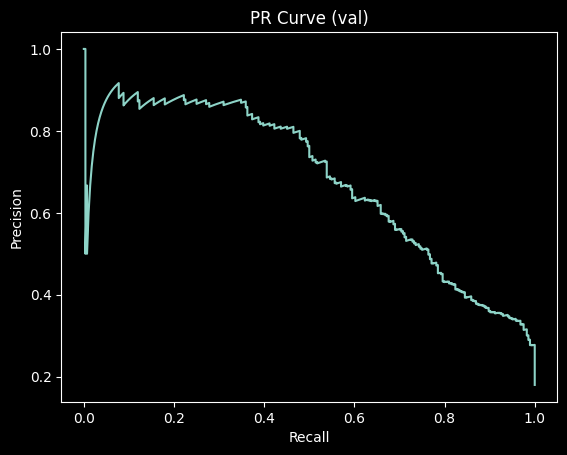

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

prec, rec, thr_list = precision_recall_curve(y_val_true, y_val_proba)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve (val)")
plt.show()


EfficientNet 기반 CNN 모델을 활용하여 피부 병변의 악성 여부를 예측하였다. 테스트 데이터에서 AUC 0.87을 기록하여 양·악성 병변을 안정적으로 구분할 수 있음을 확인하였다. 특히 악성 병변에 대해 재현율 0.72를 달성하여 미탐을 최소화하는 방향으로 모델을 설계하였다. 다만 정밀도는 0.49로 일부 양성 병변이 악성으로 오탐되는 한계가 존재하나, 이는 선별(screening) 목적의 의료 AI 특성을 고려할 때 허용 가능한 수준으로 판단됨

In [64]:
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_auc",
    mode="max",
    save_best_only=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[ckpt]
)


Epoch 1/10


2025-12-17 10:38:47.992116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype resource
	 [[{{node Placeholder/_11}}]]
2025-12-17 10:38:47.992518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype resource
	 [[{{node Placeholder/_10}}]]


201/201 [==============================] - 22s 104ms/step - loss: 0.4565 - auc: 0.7003 - accuracy: 0.8016 - val_loss: 0.4613 - val_auc: 0.6908 - val_accuracy: 0.8201
Epoch 2/10
201/201 [==============================] - 22s 107ms/step - loss: 0.4602 - auc: 0.6953 - accuracy: 0.7954 - val_loss: 0.4442 - val_auc: 0.6914 - val_accuracy: 0.8201
Epoch 3/10
201/201 [==============================] - 22s 110ms/step - loss: 0.4509 - auc: 0.7155 - accuracy: 0.7988 - val_loss: 0.4414 - val_auc: 0.6875 - val_accuracy: 0.8201
Epoch 4/10
201/201 [==============================] - 25s 122ms/step - loss: 0.4484 - auc: 0.7179 - accuracy: 0.7993 - val_loss: 0.4375 - val_auc: 0.6885 - val_accuracy: 0.8201
Epoch 5/10
201/201 [==============================] - 28s 140ms/step - loss: 0.4493 - auc: 0.7189 - accuracy: 0.7988 - val_loss: 0.4403 - val_auc: 0.6865 - val_accuracy: 0.8201
Epoch 6/10
201/201 [==============================] - 31s 154ms/step - loss: 0.4470 - auc: 0.7203 - accuracy: 0.7968 - val_los

In [65]:
print(max(history.history["val_auc"]))


0.6913902759552002


In [66]:
print(tr_df["target"].value_counts())


target
0    5135
1    1277
Name: count, dtype: int64


In [67]:
import tensorflow as tf

ckpt = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_auc",
    mode="max",
    save_best_only=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[ckpt]
)


Epoch 1/10
201/201 [==============================] - 22s 108ms/step - loss: 0.4402 - auc: 0.7364 - accuracy: 0.7993 - val_loss: 0.4325 - val_auc: 0.6951 - val_accuracy: 0.8201
Epoch 2/10
201/201 [==============================] - 21s 106ms/step - loss: 0.4411 - auc: 0.7329 - accuracy: 0.8010 - val_loss: 0.4357 - val_auc: 0.6883 - val_accuracy: 0.8201
Epoch 3/10
201/201 [==============================] - 20s 101ms/step - loss: 0.4437 - auc: 0.7292 - accuracy: 0.7996 - val_loss: 0.4452 - val_auc: 0.6910 - val_accuracy: 0.8201
Epoch 4/10
201/201 [==============================] - 22s 110ms/step - loss: 0.4471 - auc: 0.7237 - accuracy: 0.7976 - val_loss: 0.4377 - val_auc: 0.6876 - val_accuracy: 0.8201
Epoch 5/10
201/201 [==============================] - 26s 128ms/step - loss: 0.4432 - auc: 0.7281 - accuracy: 0.8055 - val_loss: 0.4428 - val_auc: 0.6871 - val_accuracy: 0.8201
Epoch 6/10
201/201 [==============================] - 26s 130ms/step - loss: 0.4440 - auc: 0.7238 - accuracy: 0.806

In [68]:
model = tf.keras.models.load_model("best_model.keras")
